In [1]:
import getpass
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Trigger Monitoring Walkthrough

In [2]:
# Authenticate to use EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [4]:
# Load information about available rates and their fits

rates = pd.read_csv("./data/rates_with_fit.csv",
                    dtype={"trigger": str,
                           "function": str,
                           "sigma": float,
                           "run": int,
                           "mode": str},
                    index_col=0)
rates.head(1)

,trigger,function,sigma,run,mode
0,AlCa_EcalEtaEBonly,-0.577724010406387+x*(0.062083640099194+ x*(-0...,0.357559,304797,l1_hlt_collisions2017/v282


In [5]:
# Load information about trigger keys

keys = pd.read_csv("./data/keys.csv",
                   names=["run", "trigger_mode", "l1_key", "hlt_key"])
keys.head(1)

,run,trigger_mode,l1_key,hlt_key
0,300064,l1_hlt_collisions2017/v170,l1_trg_collisions2017/v61,/cdaq/physics/Run2017/2e34/v2.1.0/HLT/V1


In [6]:
# Add LHC fill number

fills = pd.read_csv("./data/lhc_fills.csv",
                    names=["run", "fill"])
rates = pd.merge(rates, fills, on="run")
rates.head(1)

,trigger,function,sigma,run,mode,fill
0,AlCa_EcalEtaEBonly,-0.577724010406387+x*(0.062083640099194+ x*(-0...,0.357559,304797,l1_hlt_collisions2017/v282,6291


In [7]:
# Select a trigger (most frequent muon based trigger)

SELECT_TRIGGER = rates[rates.trigger.str.contains("muon", na=False)].trigger.describe().top

In [8]:
# Select run

SELECT_RUN = rates[(rates.trigger == SELECT_TRIGGER)].iloc[0].run

In [9]:
# Load rates

data = pd.DataFrame()

sample = rates[(rates.trigger == SELECT_TRIGGER) & (rates.run == SELECT_RUN)].iloc[0]

# Load rates from .npy
rates_raw = np.load("/eos/cms/store/cmst3/group/dehep/adpol/trigger/%s/%s.npy" % (SELECT_RUN, SELECT_TRIGGER))

# Sort rates based on <PU>
rates_sorted = rates_raw[:,np.argsort(rates_raw[0])]

# Reverse sorting
rates_sorted_reverse = np.fliplr(rates_sorted)

# Save rates to series
sample["rates"] = np.array(rates_sorted_reverse)

# Save rates to dataframe
data = data.append(pd.Series(sample))

In [10]:
# Calculate prediction accuracy

def get_mse(rates, function):
    x = rates[0]
    prediction = eval(function.replace('sinh', 'np.sinh'))
    return ((rates[1] - prediction) ** 2).mean(axis=0)

data["mse"] = data.apply(lambda row: get_mse(row.rates, row.function), axis=1)

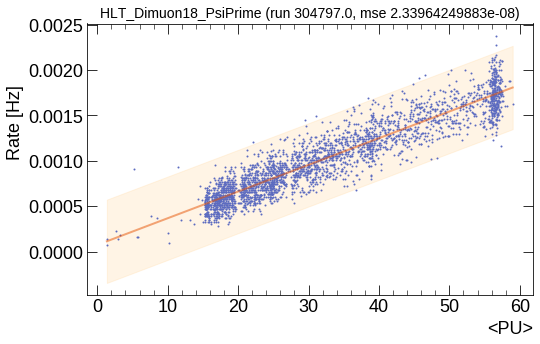

In [11]:
# Plot Rate vs <PU>

def PlotTrigger(ax, sample):
    x = sample.rates[0]
    prediction = eval(sample.function.replace('sinh', 'np.sinh'))
    
    ax.plot(x,
            sample.rates[1],
            'o',
            color=color_palette["Indigo"][400],
            markersize=1)
    
    ax.plot(x,
            prediction,
            '-',
            color=color_palette["Orange"][900],
            linewidth=2,
            alpha=0.5)
    
    smax = prediction + sample.sigma
    smin = prediction - sample.sigma
    ax.fill_between(x,
                    smax,
                    smin,
                    color=color_palette["Orange"][200],
                    alpha=0.2)

sample = data.iloc[0]

fig = plt.figure()
ax = fig.add_subplot(111)

PlotTrigger(ax, sample)

ax.set_title("%s (run %s, mse %s)" % (sample.trigger, sample.run, sample.mse))
ax.set_ylabel("Rate [Hz]", horizontalalignment="left", x=1.0)
ax.set_xlabel("<PU>", horizontalalignment="right", x=1.0)
plt.show();

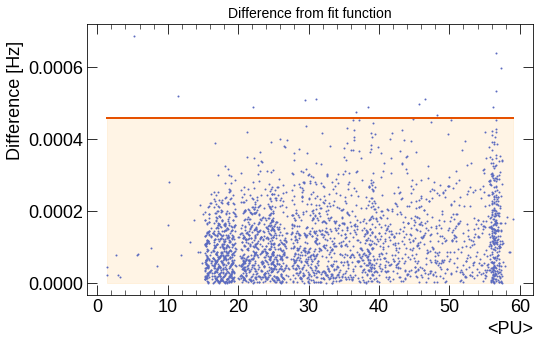

In [12]:
# Plot reported error difference

def PlotError(ax, sample):
    x = sample.rates[0]
    prediction = eval(sample.function.replace('sinh', 'np.sinh'))
    error = abs(np.array(prediction) - np.array(sample.rates[1]))
      
    ax.plot(x,
            error,
            'o',
            color=color_palette["Indigo"][400],
            markersize=1)
    
    ax.plot([x[-1], x[0]],
            [sample.sigma, sample.sigma],
            '-',
            color=color_palette["Orange"][900],
            linewidth=2)

    ax.fill_between([x[-1], x[0]],
                    sample.sigma,
                    0,
                    color=color_palette["Orange"][200],
                    alpha=0.2)
    
fig = plt.figure()
ax = fig.add_subplot(111)

PlotError(ax, sample)

ax.set_title("Difference from fit function")
ax.set_ylabel("Difference [Hz]", horizontalalignment="left", x=1.0)
ax.set_xlabel("<PU>", horizontalalignment="right", x=1.0)
plt.show();

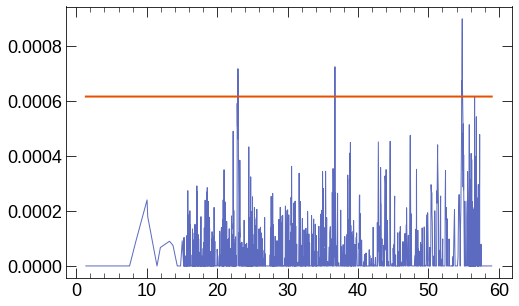

In [13]:
# Visualize alarms for Page-Hinkley Test

def PageHinkleyTest(sample, tolerance=0.0001, warm_up_fraction=0.1, prediction=None):
    """Page-Hinkley statistics for an increasing jump in mean"""
    
    if prediction is not None:
        sample = sample - prediction
    
    sample_length = len(sample)
    errors = -np.ones(sample_length)
    warm_up_limit = int(sample_length*warm_up_fraction)
    
    # Warm-up
    total = sample[0]
    errors[0] = 0
    for i in range(2, warm_up_limit+1):
        total = total + sample[i] #update sum
        errors[i] = max(errors[i-1] - sample[i] + total / i - tolerance, 0)
    
    treshold = max(errors)
    for i in range(warm_up_limit+1, sample_length):
        total=total+sample[i] #update sum
        errors[i] = max(errors[i-1]-sample[i] + total/i - tolerance, 0) #upadte ph stats
    
    errors[1] = 0
    return errors, treshold

def PlotPageHinkley(ax, sample, ph, treshold):
    x = sample.rates[0]
    
    ax.plot(x,
            ph,
            '-',
            color=color_palette["Indigo"][400],
            linewidth=1)
    
    ax.plot(x,
            np.ones(len(ph))*treshold,
            '-',
            color=color_palette["Orange"][900],
            linewidth=2)    
    
fig = plt.figure()
ax = fig.add_subplot(111)

x = sample.rates[0]

ph, treshold = PageHinkleyTest(sample.rates[1],
                               prediction=eval(sample.function.replace('sinh', 'np.sinh')))

PlotPageHinkley(ax, sample, ph, treshold)

plt.show();

In [14]:
# Load all rates arrays for a given trigger

data = pd.DataFrame()

for _, sample in rates[rates.trigger  == SELECT_TRIGGER].iterrows():
    try:
        # Load rates from .npy
        rates = np.load("/eos/cms/store/cmst3/group/dehep/adpol/trigger/%s/%s.npy" % (sample.run, sample.trigger))

        # Sort rates based on <PU>
        rates_sorted = rates[:,np.argsort(rates[0])]

        # Reverse sorting
        rates_sorted_reverse =  np.fliplr(rates_sorted)

        # Save rates to dataframe
        sample["rates"] = rates_sorted_reverse

    except:
        sample["rates"] = np.nan
    data = data.append(pd.Series(sample))

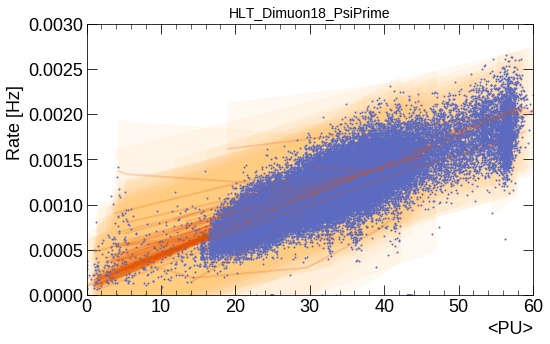

In [15]:
# Plot all the data for a given trigger

fig = plt.figure()
ax = fig.add_subplot(111)

for _, i in data.iterrows():
    if np.isnan(i.rates).any():
        continue
    x = i.rates[0]
    prediction = eval(i.function.replace('sinh', 'np.sinh'))
       
    ax.plot(i.rates[0],
            i.rates[1],
            'o',
            color=color_palette["Indigo"][400],
            markersize=1,
            alpha=1)
    
    ax.plot(i.rates[0],
            prediction,
            '-',
            color=color_palette["Orange"][900],
            linewidth=2,
            alpha=0.2)

    smax = prediction + i.sigma
    smin = prediction - i.sigma
    ax.fill_between(i.rates[0],
                    smax,
                    smin,
                    color=color_palette["Orange"][200],
                    alpha=0.1)


ax.set_title("%s" % SELECT_TRIGGER)
ax.set_ylabel("Rate [Hz]", horizontalalignment="left", x=1.0)
ax.set_xlabel("<PU>", horizontalalignment="right", x=1.0)

plt.ylim([0, 0.003])
plt.xlim([0, 60])
plt.show();